In [293]:
%cd '/content/drive/MyDrive/3semester/8160/hw4'

/content/drive/MyDrive/3semester/8160/hw4


In [292]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [294]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
from PIL import Image
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import time
import itertools

## Read dataset

In [322]:
class Dataloader(Dataset):
    def __init__(self, localization, classification):
        self.localization = Path(localization)

        if classification:
            self.classification = Path(classification)
            # Read CSV for classification
            self.classification_v = pd.read_csv(os.path.join(classification, "train.csv"))
            # Paths for classification images
            self.class_image = os.path.join(classification, "data", "work_van")
            # Subfolder for classification
            class_img = [file for file in os.listdir(self.class_image) if file.endswith(".jpg")]
            self.class_img = class_img
            # print(class_img)

        else:
            # Read CSV for localization
            self.localization_v = pd.read_csv(os.path.join(localization, 'train.csv'))
            # Paths for localization images
            self.local_image = os.path.join(localization, "classd")
            # Subfolder for localization
            loc_img = [file for file in os.listdir(self.local_image) if file.endswith(".jpg")]
            self.loc_img = loc_img

    def __len__(self):
        if hasattr(self, 'loc_img'):
            return len(self.loc_img)
        elif hasattr(self, 'class_img'):
            return len(self.class_img)
        else:
            return 0

    def __getitem__(self, idx):
        if hasattr(self, 'loc_img'):
            img_name = self.loc_img[idx]
            img_path = os.path.join(self.local_image, img_name)
            img_data = io.imread(img_path)
            localization_vv = self.localization_v.iloc[idx]
            dic = {'image': img_data, 'localization_v': localization_vv}

        elif hasattr(self, 'class_img'):
            img_name = self.class_img[idx]
            img_path = os.path.join(self.class_image, img_name)
            img_data = io.imread(img_path)
            classification_vv = self.classification_v.iloc[idx]
            dic = {'image': img_data, 'class_label': classification_vv}

        else:
            dic = {}

        return dic


In [324]:
localization = "/content/drive/MyDrive/3semester/8160/hw4/localize/"
classification = "/content/drive/MyDrive/3semester/8160/hw4/classification/"
dataset = Dataloader(localization, classification)

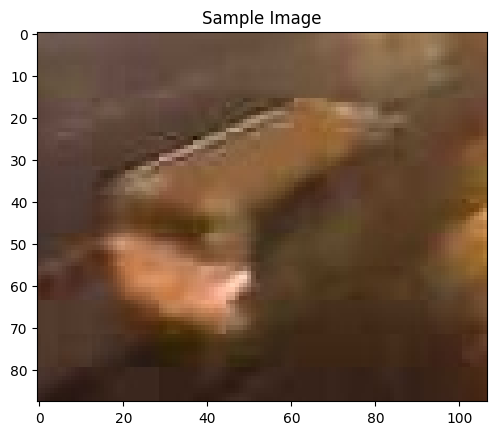

In [326]:
image_data = dataset[11]['image']
plt.imshow(image_data)
plt.title("Sample Image")
plt.show()

## Resizing

In [327]:
class Rescale(object):

    def __init__(self, output_size):
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        elif isinstance(output_size, tuple):
            assert len(output_size) == 2
            self.output_size = output_size
        else:
            raise ValueError("Should be tuple or int")

    def __call__(self, sample):
        image = sample['image']
        class_label = sample.get('class_label', None)
        loc_label = sample.get('loc_label', None)

        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'class_label': class_label, 'loc_label': loc_label}

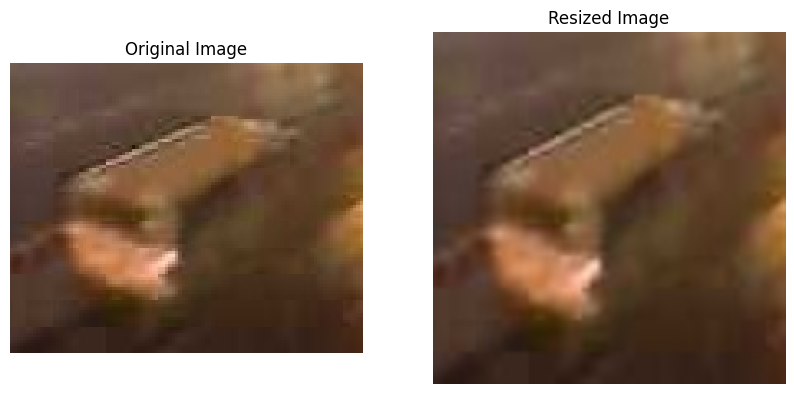

In [328]:
sample = dataset[11]
rescale_transform = Rescale(output_size=(224, 224))
transformed_sample = rescale_transform(sample)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample['image'])
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(transformed_sample['image'])
axs[1].set_title('Resized Image')
axs[1].axis('off')

plt.show()

## Filp: Horizontal / Vertical

In [329]:
class Flip(object):
    def __init__(self, axis):
      assert axis in (0, 1)
      self.axis = axis

    def __call__(self, sample):
      image = sample['image']
      class_label = sample.get('class_label', None)
      loc_label = sample.get('loc_label', None)
      tensor = torch.from_numpy(image)
      image = torch.flip(tensor, [self.axis])

      return {"image":image, "loc_label":loc_label,"class_label":class_label}


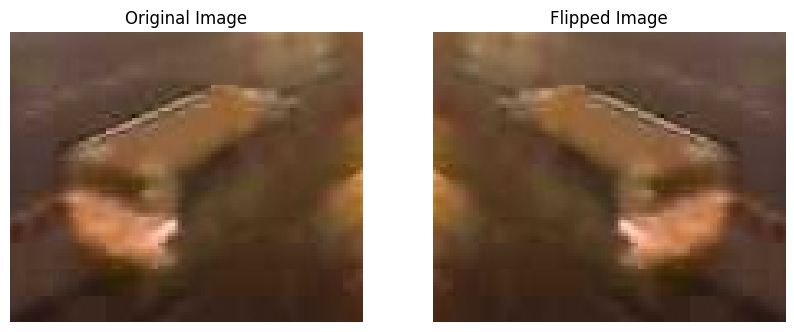

In [330]:
f = Flip(1)
sample = dataset[11]
flipped_sample = f(sample)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample['image'])
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(flipped_sample['image'])
axs[1].set_title('Flipped Image')
axs[1].axis('off')
plt.show()

## Totensor & Normalization

In [331]:
class ToTensor_normal(object):
      def __init__(self, mean=None, std=None):
        self.mean = mean
        self.std = std

      def __call__(self, sample):
        image = sample['image']
        class_label = sample.get('class_label', None)
        loc_label = sample.get('loc_label', None)
        image = np.transpose(image, (2, 0, 1))
        #tensor
        tensor = torch.from_numpy(image).float()
        #normalize
        if self.mean is not None and self.std is not None:
          tensor = transforms.functional.normalize(tensor, self.mean, self.std)

        return {"image": tensor, "loc_label": loc_label, "class_label": class_label}

In [332]:
tn_transform = ToTensor_normal(sample)
normalized_tensor_sample = tn_transform(sample)
normalized_image_tensor = normalized_tensor_sample['image']
normalized_image_tensor = torch.clamp(normalized_image_tensor, 0, 1)
print("Original:", sample['image'].shape)
print("Normalized:", normalized_tensor_sample['image'].shape)

Original: (88, 107, 3)
Normalized: torch.Size([3, 88, 107])
